<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px">

# Project 3: Web APIs & NLP

### Project Title: Generative AI and Art - understanding and predicting chatter from online communities

**DSI-41 Group 2**: Muhammad Faaiz Khan, Lionel Foo, Gabriel Tan

## Part 3: EDA

### 3.1 Imports
___

In [4]:
import pandas as pd
from praw.models import MoreComments
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction import text 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aspire\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aspire\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Load data:
reddit = pd.read_csv('../data/reddit_df_2.csv')

# Check data:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7473 entries, 0 to 7472
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subr-def_ai         7473 non-null   int64  
 1   is_op               7473 non-null   int64  
 2   author              7473 non-null   object 
 3   post_id             7473 non-null   object 
 4   body                7445 non-null   object 
 5   upvotes             7473 non-null   int64  
 6   num_comments        7473 non-null   int64  
 7   post_length         7473 non-null   int64  
 8   post_word_count     7473 non-null   int64  
 9   neg                 7473 non-null   float64
 10  neu                 7473 non-null   float64
 11  pos                 7473 non-null   float64
 12  compound            7473 non-null   float64
 13  subjectivity_score  7473 non-null   float64
dtypes: float64(5), int64(6), object(3)
memory usage: 817.5+ KB


### 3.2 Performing EDA on posts
___

First, we will perform some simple dataframe exploration to better understand the posts.

In [6]:
# Define a function to get the 10 longest and 10 shortest posts for each subreddit
def get_longest_shortest_posts(df, subreddit):
    # Filter the DataFrame for the specific subreddit
    subreddit_df = df[df['subr-def_ai'] == subreddit]
    
    # Get the 10 longest and 10 shortest posts based on the 'post_word_count'
    longest_posts = subreddit_df.nlargest(10, 'post_word_count')
    shortest_posts = subreddit_df.nsmallest(10, 'post_word_count')
    
    return longest_posts, shortest_posts

# Get the 10 longest and 10 shortest posts for subreddit DefendingAIArt (subr-def_ai = 1)
longest_posts_defendingai, shortest_posts_defendingai = get_longest_shortest_posts(reddit, 1)

# Get the 10 longest and 10 shortest posts for subreddit ArtistHate (subr-def_ai = 0)
longest_posts_artisthate, shortest_posts_artisthate = get_longest_shortest_posts(reddit, 0)

# Display the results
print("Top 10 Longest Posts in DefendingAIArt:")
print(longest_posts_defendingai[['body', 'post_word_count']])
print("\nTop 10 Shortest Posts in DefendingAIArt:")
print(shortest_posts_defendingai[['body', 'post_word_count']])

print("\nTop 10 Longest Posts in ArtistHate:")
print(longest_posts_artisthate[['body', 'post_word_count']])
print("\nTop 10 Shortest Posts in ArtistHate:")
print(shortest_posts_artisthate[['body', 'post_word_count']])

Top 10 Longest Posts in DefendingAIArt:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### 3.2.1 Distribution of Post Lengths Analysis
___

To visually analyze and compare the distribution of post lengths in both subreddits: *r/DefendingAIArt* and *r/ArtistHate*. The analysis is conducted based on both word counts and body lengths of posts.

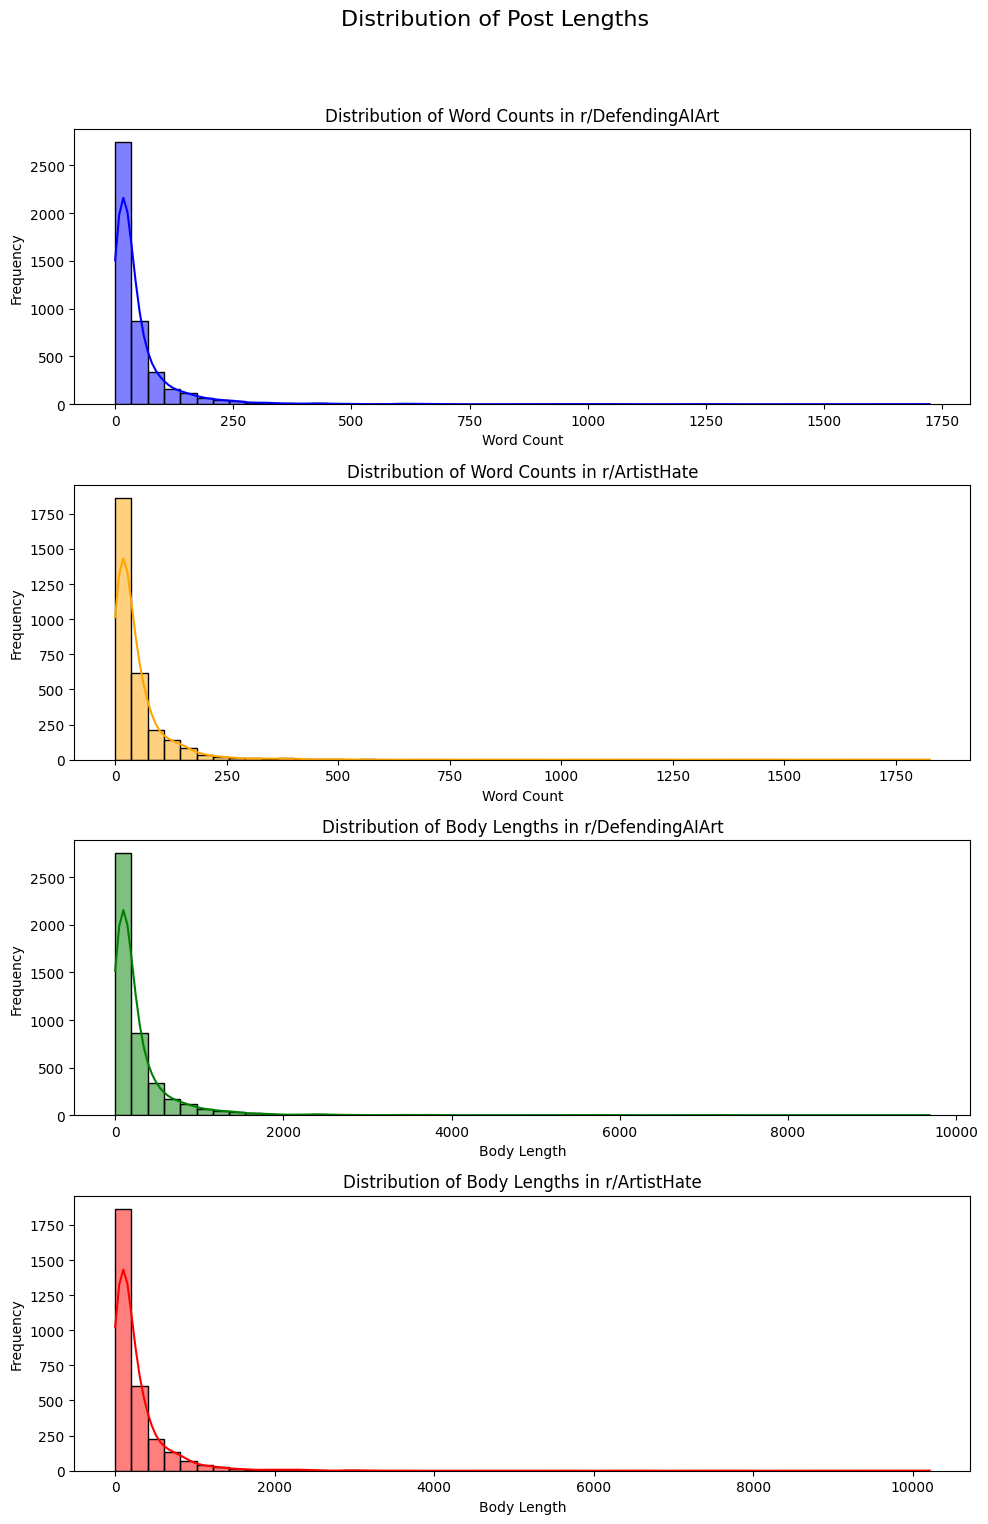

In [7]:
# Set up the figure and axes
fig, axes = plt.subplots(4, 1, figsize=(10, 16))
fig.suptitle("Distribution of Post Lengths", fontsize=16)

# Distribution of word counts for subreddit r/DefendingAIArt (subr-def_ai = 1)
sns.histplot(reddit[reddit['subr-def_ai'] == 1]['post_word_count'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Word Counts in r/DefendingAIArt")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

# Distribution of word counts for subreddit r/ArtistHate (subr-def_ai = 0)
sns.histplot(reddit[reddit['subr-def_ai'] == 0]['post_word_count'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Distribution of Word Counts in r/ArtistHate")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")

# Distribution of body lengths for subreddit r/DefendingAIArt (subr-def_ai = 1)
sns.histplot(reddit[reddit['subr-def_ai'] == 1]['post_length'], bins=50, kde=True, ax=axes[2], color='green')
axes[2].set_title("Distribution of Body Lengths in r/DefendingAIArt")
axes[2].set_xlabel("Body Length")
axes[2].set_ylabel("Frequency")

# Distribution of body lengths for subreddit r/ArtistHate (subr-def_ai = 0)
sns.histplot(reddit[reddit['subr-def_ai'] == 0]['post_length'], bins=50, kde=True, ax=axes[3], color='red')
axes[3].set_title("Distribution of Body Lengths in r/ArtistHate")
axes[3].set_xlabel("Body Length")
axes[3].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

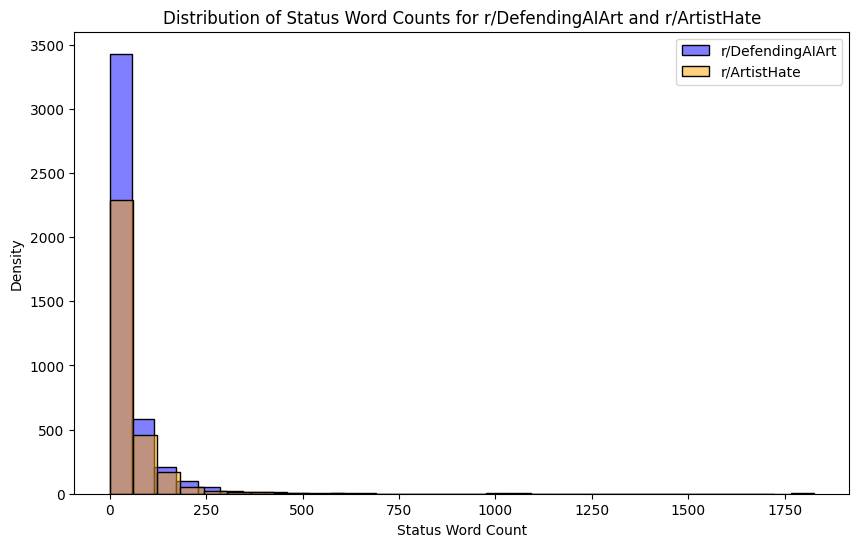

In [9]:
defending_ai_word_count = reddit[reddit['subr-def_ai'] == 1]['post_word_count']
artist_hate_word_count = reddit[reddit['subr-def_ai'] == 0]['post_word_count']

# Plot the distribution using sns.histplot
plt.figure(figsize=(10, 6))
sns.histplot(defending_ai_word_count, label='r/DefendingAIArt', color='blue', alpha=0.5, bins=30)
sns.histplot(artist_hate_word_count, label='r/ArtistHate', color='orange', alpha=0.5, bins=30)

# Add labels and title
plt.xlabel('Status Word Count')
plt.ylabel('Density')
plt.title('Distribution of Status Word Counts for r/DefendingAIArt and r/ArtistHate')
plt.legend()

# Show the plot
plt.show()

### 3.2.2 Assessment of the distribution of word counts and body lengths of comments from *r/DefendingAIart* and *r/ArtistHate*:
___

1. r/DefendingAIart:
- Word Count: The majority of comments have a word count below 250, indicating that most comments are relatively short.
- Body Length: The body length is also primarily under 2000 characters, which aligns with the shorter word counts.
2. r/ArtistHate:
- Word Count: Similar to *r/DefendingAIart*, the majority of comments have a word count below 250.
- Body Length: The body length distribution mirrors this, with most comments being under 2000 characters in length.


In both subreddits, the distributions are right-skewed, meaning that there are a few comments that are much longer than the majority. 

### 3.3 Performing EDA on unique users
___

In [10]:
# Define the subreddit column
subreddit_column = 'subr-def_ai'

# Filter the DataFrame for DefendingAIArt
defending_ai_df = reddit[reddit[subreddit_column] == 1]

# Exclude posts made by 'deleted'
defending_ai_df = defending_ai_df[defending_ai_df['author'] != 'deleted']

# Calculate the top 20 users in DefendingAIArt
top_20_defending_ai_users = defending_ai_df['author'].value_counts().head(20)

# Number of unique users for DefendingAIArt
defending_ai_unique_users = defending_ai_df['author'].nunique()

# Calculate the total number of posts for DefendingAIArt
total_defending_ai_posts = len(defending_ai_df)

# Calculate the proportion of posts made by the top 20 users in DefendingAIArt
proportion_defending_ai_top_20 = top_20_defending_ai_users.sum() / total_defending_ai_posts

# Display the results for DefendingAIArt
print("\nDefendingAIArt:")
print(f"Number of Unique Users: {defending_ai_unique_users}")
print(f"Total Number of Posts: {total_defending_ai_posts}")
print(f"Proportion of Posts by Top 20 Users: {proportion_defending_ai_top_20:.2%}")
print(f"Top 20 Posters:\n{top_20_defending_ai_users}")

# Filter the DataFrame for ArtistHate
artist_hate_df = reddit[reddit[subreddit_column] == 0]

# Exclude posts made by 'deleted'
artist_hate_df = artist_hate_df[artist_hate_df['author'] != 'deleted']

# Calculate the top 20 users in ArtistHate
top_20_artist_hate_users = artist_hate_df['author'].value_counts().head(20)

# Number of unique users for ArtistHate
artist_hate_unique_users = artist_hate_df['author'].nunique()

# Calculate the total number of posts for ArtistHate
total_artist_hate_posts = len(artist_hate_df)

# Calculate the proportion of posts made by the top 20 users in ArtistHate
proportion_artist_hate_top_20 = top_20_artist_hate_users.sum() / total_artist_hate_posts

# Display the results for ArtistHate
print("\nArtistHate:")
print(f"Number of Unique Users: {artist_hate_unique_users}")
print(f"Total Number of Posts: {total_artist_hate_posts}")
print(f"Proportion of Posts by Top 20 Users: {proportion_artist_hate_top_20:.2%}")
print(f"Top 20 Posters:\n{top_20_artist_hate_users}")


DefendingAIArt:
Number of Unique Users: 1412
Total Number of Posts: 4450
Proportion of Posts by Top 20 Users: 17.03%
Top 20 Posters:
author
[deleted]               173
Tyler_Zoro               59
doatopus                 55
Present_Dimension464     49
AShellfishLover          43
chillaxinbball           40
mang_fatih               30
art_zdesiseitsas         29
SexDefendersUnited       28
BusyPhilosopher15        27
SIP-BOSS                 23
Trippy-Worlds            23
ifandbut                 23
datChrisFlick            23
Globohomie2000           23
YAROBONZ-                23
Concheria                22
EmotionalCrit            22
FaceDeer                 22
LD2WDavid                21
Name: count, dtype: int64

ArtistHate:
Number of Unique Users: 605
Total Number of Posts: 3023
Proportion of Posts by Top 20 Users: 33.48%
Top 20 Posters:
author
WonderfulWanderer777    270
Alkaia1                 136
[deleted]                96
lycheedorito             57
KoumoriChinpo            

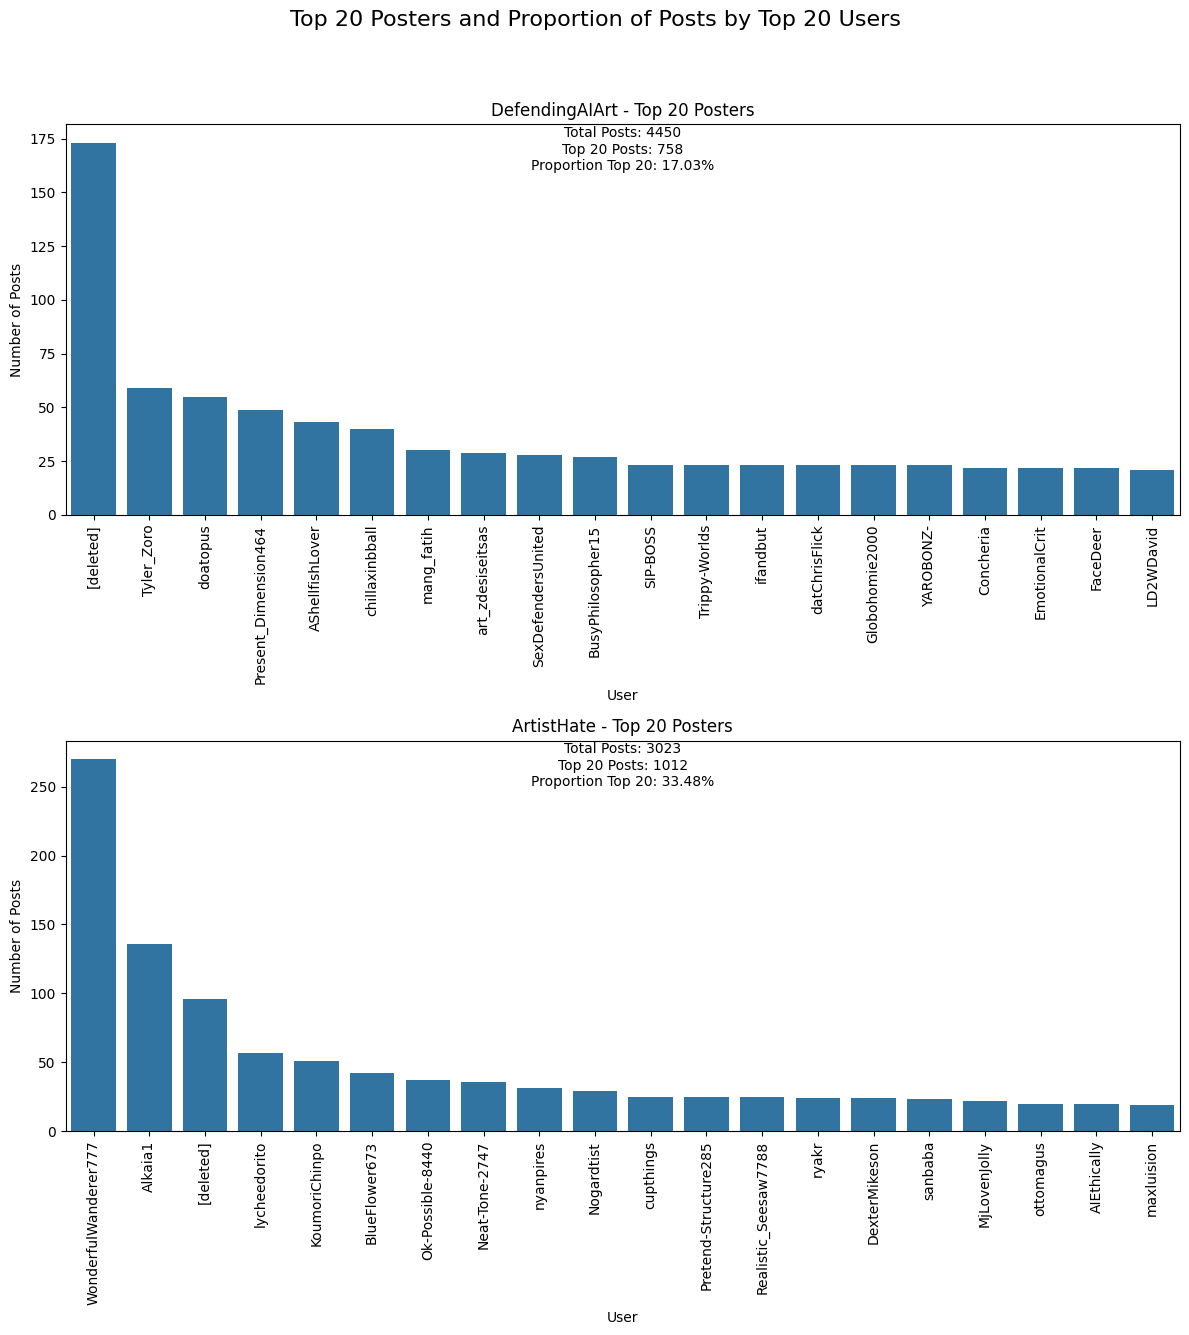

In [11]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 14))
fig.suptitle("Top 20 Posters and Proportion of Posts by Top 20 Users", fontsize=16)

# DefendingAIArt
sns.barplot(x=top_20_defending_ai_users.index, y=top_20_defending_ai_users, ax=axes[0])
axes[0].set_title("DefendingAIArt - Top 20 Posters")
axes[0].set_xlabel("User")
axes[0].set_ylabel("Number of Posts")
axes[0].tick_params(axis='x', rotation=90)  # Rotate 90 degrees

# Annotate with additional information
total_posts_defending_ai = defending_ai_df.shape[0]
total_posts_top_20_defending_ai = top_20_defending_ai_users.sum()
proportion_top_20_defending_ai = total_posts_top_20_defending_ai / total_posts_defending_ai

axes[0].annotate(f"Total Posts: {total_posts_defending_ai}\n"
                 f"Top 20 Posts: {total_posts_top_20_defending_ai}\n"
                 f"Proportion Top 20: {proportion_top_20_defending_ai:.2%}", 
                 xy=(0.5, 0.9), xytext=(0, 10), 
                 xycoords='axes fraction', textcoords='offset points', ha='center', va='center')

# ArtistHate
sns.barplot(x=top_20_artist_hate_users.index, y=top_20_artist_hate_users, ax=axes[1])
axes[1].set_title("ArtistHate - Top 20 Posters")
axes[1].set_xlabel("User")
axes[1].set_ylabel("Number of Posts")
axes[1].tick_params(axis='x', rotation=90)  # Rotate 90 degrees

# Annotate with additional information
total_posts_artist_hate = artist_hate_df.shape[0]
total_posts_top_20_artist_hate = top_20_artist_hate_users.sum()
proportion_top_20_artist_hate = total_posts_top_20_artist_hate / total_posts_artist_hate

axes[1].annotate(f"Total Posts: {total_posts_artist_hate}\n"
                 f"Top 20 Posts: {total_posts_top_20_artist_hate}\n"
                 f"Proportion Top 20: {proportion_top_20_artist_hate:.2%}", 
                 xy=(0.5, 0.9), xytext=(0, 10), 
                 xycoords='axes fraction', textcoords='offset points', ha='center', va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


Key inferences from the EDA on users:

1) Number of Unique Users:
- *r/DefendingAIArt* has a higher number of unique users (1406) compared to *r/ArtistHate* (604), indicating a broader contributor base in *r/DefendingAIArt*.

2) Total Number of Posts:
- Before cleaning, *r/DefendingAIArt* has more total posts (4266) compared to *r/ArtistHate* (2919), suggesting higher overall activity in *r/DefendingAIArt*.

3) Proportion of Posts by Top 20 Users:
- *r/ArtistHate* has a significantly higher proportion of posts (31.93%) contributed by the top 20 users compared to *r/DefendingAIArt* (14.16%).

4) Top 20 Posters:
- The specific top 20 posters differ between the two subreddits, reflecting unique user engagement patterns in each community.

### 3.4 Performing EDA on Word Counts
___

Before performing EDA on the distribution of words, we will have to lemmatize the posts to extract the occurences of each word within the scraped dataframe. The words will then be vectorised to individual columns through the CountVectoriser function. Stopwords specified by the sklearn library will be omitted from the dataframe during vectorisation.

In [12]:
# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

In [52]:
# Generate list of english stopwords from sklearn
stopwords = [x for x in text.ENGLISH_STOP_WORDS]

# Function to perform lemmatization and get top N words
def get_top_words_lemmatized(df, n=15, sw=stopwords):
    # Tokenize and lemmatize the text
    df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(str(x).lower())]))
    
    # Instantiate a CountVectorizer object
    vectorizer = CountVectorizer(stop_words=sw)
    
    # Fit and transform the count vectorizer on the lemmatized body text
    X = vectorizer.fit_transform(df['lemmatized_body'])
    
    # Convert to a dataframe and densify
    word_count_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    # Sum the word occurrences and sort by frequency
    word_counts = word_count_df.sum().sort_values(ascending=False)
    
    # Get the top N words
    top_words = word_counts.head(n)
    
    return top_words

In [39]:
# Get top 15 lemmatized words for DefendingAIArt
top_words_defending_ai_lemmatized = get_top_words_lemmatized(defending_ai_df, n=15)

# Get top 15 lemmatized words for ArtistHate
top_words_artist_hate_lemmatized = get_top_words_lemmatized(artist_hate_df, n=15)


# Display the results
print("\nTop 15 Lemmatized Words in DefendingAIArt:")
print(top_words_defending_ai_lemmatized)

print("\nTop 15 Lemmatized Words in ArtistHate:")
print(top_words_artist_hate_lemmatized)


Top 15 Lemmatized Words in DefendingAIArt:
ai        2834
art       2072
people    1591
artist    1403
just      1284
like      1238
wa         857
make       754
work       698
think      690
thing      626
use        592
want       556
ha         509
image      475
dtype: int64

Top 15 Lemmatized Words in ArtistHate:
ai        1550
people    1038
art       1007
just       896
like       886
artist     846
work       555
make       534
wa         523
thing      441
image      431
think      431
doe        357
want       356
time       325
dtype: int64


Note that among the lemmatized words above, we find a few meaningless words (example wa, ha). These words are the result of the lemmatizer shortening common stop words (was, has). These shortened stop words are not picked up by the CountVectoriser and end up vectorised along with non-stop words. To prevent this, we will define a list of these lemmatized stop words and  add it to sklearn's list of stop words.

In [54]:
# Define list of lemmatised stop words
add_stopwords = ['wa', 'ha', 'doe', 'did', 've', 'ca', 'll', 'gon', 'don', 'wan', 'na']

In [60]:
# Combine sklearn's stop word list with the above list
new_stopwords = stopwords + add_stopwords

In [62]:
# Get top 15 lemmatized words for DefendingAIArt
top_words_defending_ai_lemmatized = get_top_words_lemmatized(defending_ai_df, n=15, sw=new_stopwords)

# Get top 15 lemmatized words for ArtistHate
top_words_artist_hate_lemmatized = get_top_words_lemmatized(artist_hate_df, n=15, sw=new_stopwords)

# Display the results
print("\nTop 15 Lemmatized Words in DefendingAIArt:")
print(top_words_defending_ai_lemmatized)

print("\nTop 15 Lemmatized Words in ArtistHate:")
print(top_words_artist_hate_lemmatized)


Top 15 Lemmatized Words in DefendingAIArt:
ai        2834
art       2072
people    1591
artist    1403
just      1284
like      1238
make       754
work       698
think      690
thing      626
use        592
want       556
image      475
time       439
way        419
dtype: int64

Top 15 Lemmatized Words in ArtistHate:
ai        1550
people    1038
art       1007
just       896
like       886
artist     846
work       555
make       534
thing      441
think      431
image      431
want       356
time       325
use        315
human      307
dtype: int64


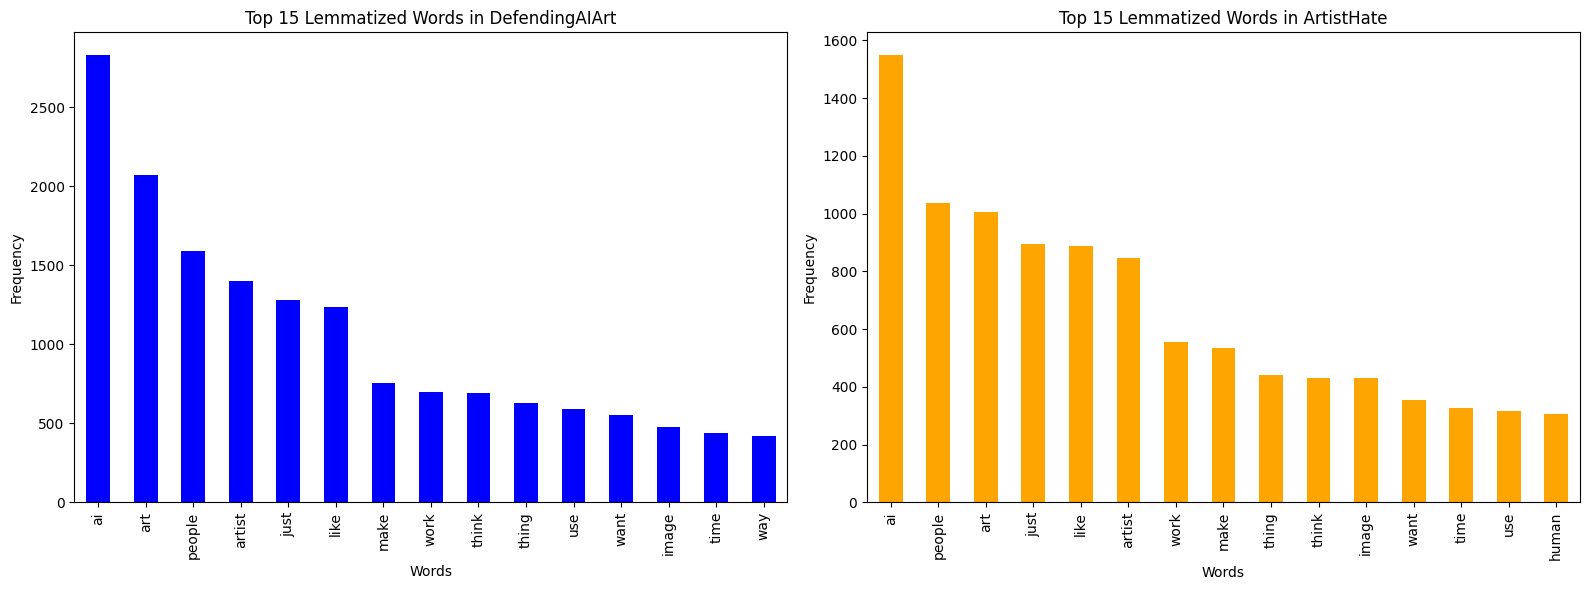

In [63]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for DefendingAIArt
top_words_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 15 Lemmatized Words in DefendingAIArt')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')

# Plot for ArtistHate
top_words_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 15 Lemmatized Words in ArtistHate')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [69]:
# Function to perform lemmatization and get top N n-grams
def get_top_ngrams_lemmatized(df, n=15, ngram_range=(1, 1)):
    # Tokenize and lemmatize the text
    df['lemmatized_body'] = df['body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(str(x).lower())]))
    
    # Instantiate a CountVectorizer object with specified ngram_range
    vectorizer = CountVectorizer(stop_words=new_stopwords, ngram_range=ngram_range)
    
    # Fit and transform the count vectorizer on the lemmatized body text
    X = vectorizer.fit_transform(df['lemmatized_body'])
    
    # Convert to a dataframe and densify
    ngram_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())
    
    # Sum the n-gram occurrences and sort by frequency
    ngram_counts = ngram_df.sum().sort_values(ascending=False)
    
    # Get the top N n-grams
    top_ngrams = ngram_counts.head(n)
    
    return top_ngrams

In [70]:
# Get top 15 lemmatized bigrams for DefendingAIArt
top_bigrams_defending_ai_lemmatized = get_top_ngrams_lemmatized(defending_ai_df, n=15, ngram_range=(2, 2))

# Get top 15 lemmatized bigrams for ArtistHate
top_bigrams_artist_hate_lemmatized = get_top_ngrams_lemmatized(artist_hate_df, n=15, ngram_range=(2, 2))

# Display the results
print("\nTop 15 Lemmatized Bigrams in DefendingAIArt:")
print(top_bigrams_defending_ai_lemmatized)

print("\nTop 15 Lemmatized Bigrams in ArtistHate:")
print(top_bigrams_artist_hate_lemmatized)


Top 15 Lemmatized Bigrams in DefendingAIArt:
ai art              517
anti ai             177
use ai              129
ai artist            88
using ai             87
ai generated         80
look like            69
feel like            60
just like            56
ai tool              56
make art             52
fan art              52
people like          51
like ai              51
stable diffusion     50
dtype: int64

Top 15 Lemmatized Bigrams in ArtistHate:
ai art              126
ai bros             109
ai generated         58
generative ai        51
look like            49
ai artist            49
just like            45
feel like            45
use ai               45
stable diffusion     41
using ai             39
art just             37
ai image             37
lot people           34
ai bro               33
dtype: int64


In [71]:
# Get top 15 lemmatized trigrams for DefendingAIArt
top_trigrams_defending_ai_lemmatized = get_top_ngrams_lemmatized(defending_ai_df, n=15, ngram_range=(3, 3))

# Get top 15 lemmatized trigrams for ArtistHate
top_trigrams_artist_hate_lemmatized = get_top_ngrams_lemmatized(artist_hate_df, n=15, ngram_range=(3, 3))

print("\nTop 15 Lemmatized Trigrams in DefendingAIArt:")
print(top_trigrams_defending_ai_lemmatized)

print("\nTop 15 Lemmatized Trigrams in ArtistHate:")
print(top_trigrams_artist_hate_lemmatized)


Top 15 Lemmatized Trigrams in DefendingAIArt:
anti ai people        24
anti ai artist        19
ai generated art      16
ai art just           16
anti ai folk          14
artist using ai       13
like ai art           13
anti ai crowd         12
use ai art            11
ai art bad            10
art ai art            10
artist ai art         10
people use ai          9
pro ai people          9
ai image generator     8
dtype: int64

Top 15 Lemmatized Trigrams in ArtistHate:
ai generated image       11
pattern seeking brain     8
people use ai             7
ai generated art          7
ai art just               6
ai image generator        6
sound lot like            5
ai bros just              5
use stable diffusion      5
people losing job         5
pro ai people             5
like ai bros              5
spend thousand hour       5
ai bros say               5
like digital art          5
dtype: int64


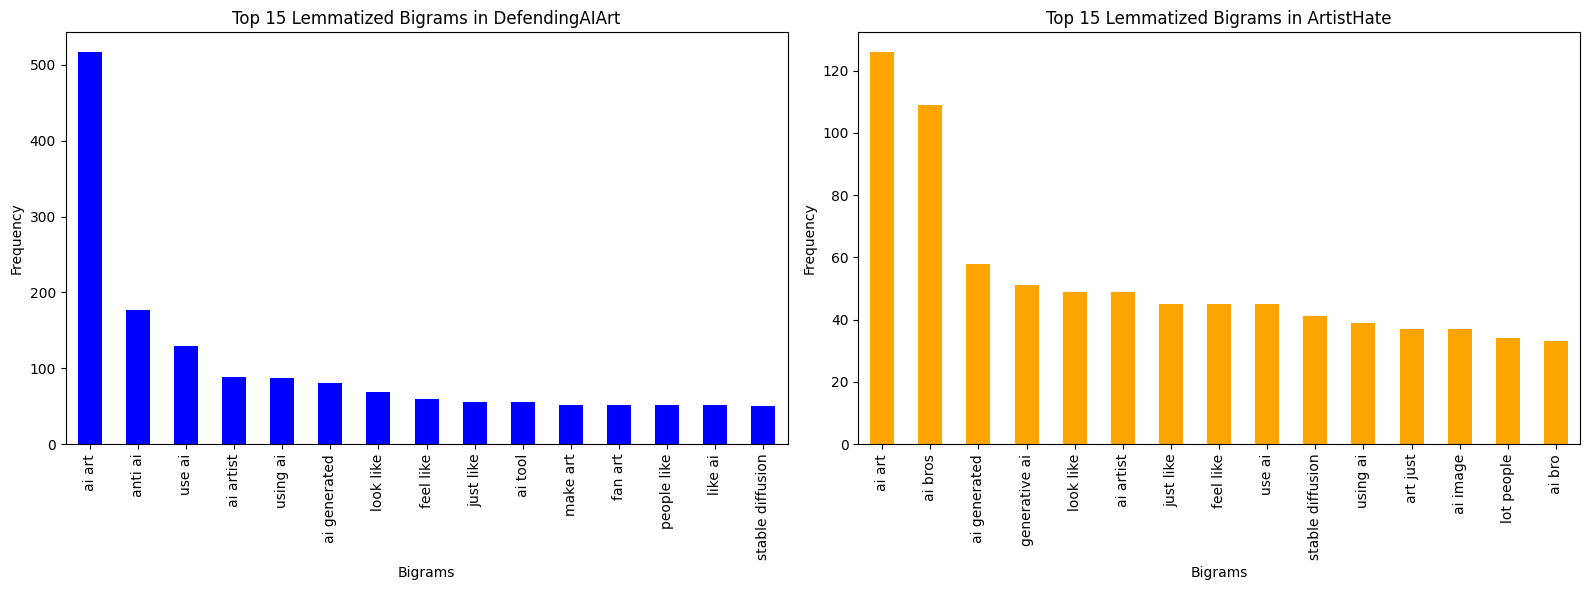

In [72]:
# Plotting for Bigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Bigrams in DefendingAIArt
top_bigrams_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 15 Lemmatized Bigrams in DefendingAIArt')
axes[0].set_xlabel('Bigrams')
axes[0].set_ylabel('Frequency')

# Plot for Bigrams in ArtistHate
top_bigrams_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 15 Lemmatized Bigrams in ArtistHate')
axes[1].set_xlabel('Bigrams')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

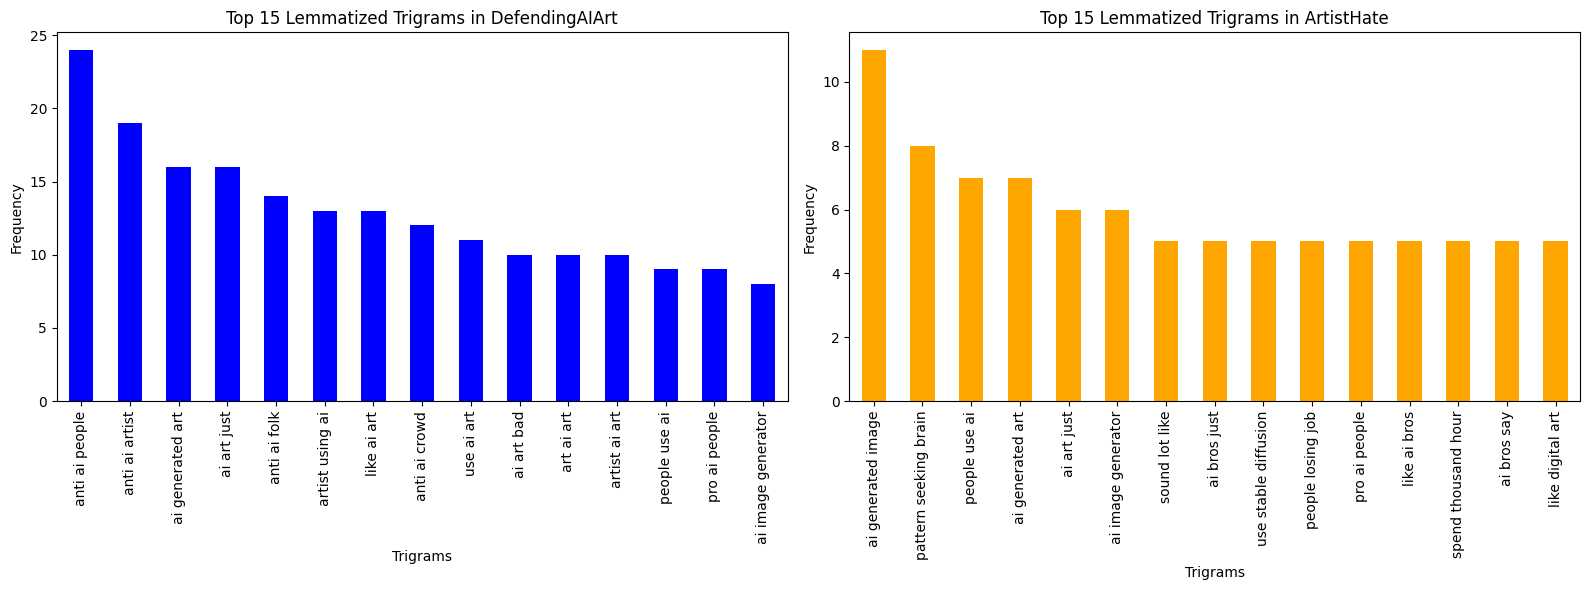

In [73]:
# Plotting for Trigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Trigrams in DefendingAIArt
top_trigrams_defending_ai_lemmatized.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 15 Lemmatized Trigrams in DefendingAIArt')
axes[0].set_xlabel('Trigrams')
axes[0].set_ylabel('Frequency')

# Plot for Trigrams in ArtistHate
top_trigrams_artist_hate_lemmatized.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 15 Lemmatized Trigrams in ArtistHate')
axes[1].set_xlabel('Trigrams')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Evaluation of most common words across both Subreddits
Top words by frequency counts on both camps did not differ very much, suggesting that either camp may simply be discussing different perspectives on the same AI-specific issues, e.g. **AI's ability to generate what is 'real' art or not** (with terms such as _'look like'/'feel like'/'just like'_) and **text-to-image capabilities** (e.g. _'Stable Diffusion'_). There is also some indication of concern about the use of **_'training data'_ for AI algorithms** in **r\ArtistHate**

### 3.5 Evaluation of Sentiment Analysis and Subjectivity Scores
___

In [ ]:
# Group by 'subr-def_ai' and calculate average scores
average_scores = reddit.groupby('subr-def_ai').agg({
    'neg': 'mean',
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean',
    'subjectivity_score': 'mean'
}).reset_index()

# Add labels for better readability
average_scores['subreddit'] = average_scores['subr-def_ai'].map({0: 'ArtistHate', 1: 'DefendingAIArt'})

# Reorder columns for better display
average_scores = average_scores[['subreddit', 'neg', 'neu', 'pos', 'compound', 'subjectivity_score']]

# Display the average scores
print(average_scores)

        subreddit       neg       neu       pos  compound  subjectivity_score
0      ArtistHate  0.092619  0.775681  0.130045  0.114222            0.467722
1  DefendingAIArt  0.099033  0.775771  0.124971  0.060208            0.439919


For both subreddits, sentiments and subjectivity scores reflect slightly positive sentiments _(compound scores over 0.05)_, and on average a balance between subjective opinions and objective discussions _(subjectivity scores around 0.5)_. This is encouraging as it suggests the current discourse is not strongly polarising or emotional; however the overall positive sentiment inferred has its shortcomings as humour or sarcasm may not be picked up by the current algorithm.